In [2]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [3]:
geo = "GSE70080"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Halvorsen2016", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [4]:
table = pd.concat((val.table.iloc[:,1:] for i,val in enumerate(data.gsms.values())), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [5]:
table

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
VALUE,-0.086,-2.085,-6.007,3.639,-2.782,-1.760,4.292,-1.220,NaN,3.740,...,-0.050,-1.290,-2.453,-3.313,-0.540,-2.535,-7.001,1.606,-4.125,-4.471
VALUE,1.018,-0.822,-5.546,2.447,-2.371,-2.375,6.413,-3.416,3.332,0.129,...,0.764,-1.001,0.505,-3.245,-3.460,0.587,-8.424,0.272,-3.178,-4.245
VALUE,NaN,0.976,-5.825,2.211,-1.764,-1.214,3.948,-2.406,1.297,1.123,...,1.821,-1.280,3.894,-3.790,-2.928,1.259,-7.345,-0.775,-1.741,-4.186
VALUE,NaN,-1.065,-4.751,3.080,-2.885,-3.239,2.489,-2.800,1.990,2.002,...,-0.533,-3.182,-1.049,-2.469,-2.862,-0.022,-6.438,0.198,-3.498,-3.456
VALUE,1.812,-2.752,-4.889,3.192,-3.381,-3.825,0.867,-3.253,0.759,0.527,...,0.014,-3.146,-1.297,-3.431,-3.977,-0.883,-7.687,-0.358,-3.891,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,NaN,NaN,-2.328,NaN,-2.012,-1.437,NaN,-1.223,NaN,0.313,...,4.010,-2.256,-1.498,-1.365,-3.788,0.118,-7.083,1.794,-2.378,-2.358
VALUE,1.145,-2.733,-4.278,NaN,-2.200,-2.346,2.720,-1.154,NaN,2.345,...,0.588,-1.046,-0.605,-0.157,-1.067,NaN,-6.153,1.971,-0.990,-1.675
VALUE,1.738,-1.975,-4.457,2.894,-3.488,-3.926,0.865,-3.051,2.622,0.860,...,3.312,-2.469,-1.154,-1.339,-3.757,0.247,-5.837,0.143,-3.048,-2.335
VALUE,NaN,NaN,-2.641,4.693,-2.142,-1.725,NaN,-1.597,NaN,0.353,...,0.581,-2.877,-0.079,-0.870,-2.462,NaN,-7.227,4.120,-0.829,-2.072


### Seperate case and controls

In [6]:
sick = np.array(["lung" in k.metadata["title"][0] for k in list(data.gsms.values())[:-1]])
controls = 1 - sick

In [7]:
sum(controls)

32

### Drop NAN

In [8]:
mask = table.isna().sum() < 10
mirnas = mirnas[mask]
table = table.loc[:, mask]

In [9]:
len(mirnas), len(table.columns)

(157, 157)

In [10]:
table = table.fillna(table.mean())

In [11]:
table

,2,3,4,5,7,9,10,11,13,14,...,258,260,262,263,265,266,268,269,270,271
VALUE,-6.007,3.639000,-2.782,-1.760,-1.220,3.740,-6.269,-3.394,-3.685,-5.669000,...,-5.445,1.591000,-0.050,-1.290,-3.313,-0.540,-7.001,1.606000,-4.125,-4.471
VALUE,-5.546,2.447000,-2.371,-2.375,-3.416,0.129,-7.171,-4.306,-6.404,-1.595000,...,-6.064,-0.694000,0.764,-1.001,-3.245,-3.460,-8.424,0.272000,-3.178,-4.245
VALUE,-5.825,2.211000,-1.764,-1.214,-2.406,1.123,-6.832,-3.880,-1.588,-2.431000,...,-5.632,0.587000,1.821,-1.280,-3.790,-2.928,-7.345,-0.775000,-1.741,-4.186
VALUE,-4.751,3.080000,-2.885,-3.239,-2.800,2.002,-5.800,-3.065,-4.183,-1.700000,...,-5.687,0.320000,-0.533,-3.182,-2.469,-2.862,-6.438,0.198000,-3.498,-3.456
VALUE,-4.889,3.192000,-3.381,-3.825,-3.253,0.527,-6.665,-3.661,-4.783,-0.675000,...,-6.467,-0.807000,0.014,-3.146,-3.431,-3.977,-7.687,-0.358000,-3.891,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-2.328,1.878921,-2.012,-1.437,-1.223,0.313,-5.728,-3.298,-9.723,-0.042141,...,-5.469,2.161000,4.010,-2.256,-1.365,-3.788,-7.083,1.794000,-2.378,-2.358
VALUE,-4.278,1.878921,-2.200,-2.346,-1.154,2.345,-5.166,-1.666,-1.246,-0.344000,...,-5.473,4.017000,0.588,-1.046,-0.157,-1.067,-6.153,1.971000,-0.990,-1.675
VALUE,-4.457,2.894000,-3.488,-3.926,-3.051,0.860,-6.092,-2.179,-2.426,1.615000,...,-5.333,1.605000,3.312,-2.469,-1.339,-3.757,-5.837,0.143000,-3.048,-2.335
VALUE,-2.641,4.693000,-2.142,-1.725,-1.597,0.353,-5.226,-2.353,-5.285,0.724000,...,-7.019,0.986000,0.581,-2.877,-0.870,-2.462,-7.227,4.120000,-0.829,-2.072


### T-test

In [12]:
X = table

In [13]:
X

,2,3,4,5,7,9,10,11,13,14,...,258,260,262,263,265,266,268,269,270,271
VALUE,-6.007,3.639000,-2.782,-1.760,-1.220,3.740,-6.269,-3.394,-3.685,-5.669000,...,-5.445,1.591000,-0.050,-1.290,-3.313,-0.540,-7.001,1.606000,-4.125,-4.471
VALUE,-5.546,2.447000,-2.371,-2.375,-3.416,0.129,-7.171,-4.306,-6.404,-1.595000,...,-6.064,-0.694000,0.764,-1.001,-3.245,-3.460,-8.424,0.272000,-3.178,-4.245
VALUE,-5.825,2.211000,-1.764,-1.214,-2.406,1.123,-6.832,-3.880,-1.588,-2.431000,...,-5.632,0.587000,1.821,-1.280,-3.790,-2.928,-7.345,-0.775000,-1.741,-4.186
VALUE,-4.751,3.080000,-2.885,-3.239,-2.800,2.002,-5.800,-3.065,-4.183,-1.700000,...,-5.687,0.320000,-0.533,-3.182,-2.469,-2.862,-6.438,0.198000,-3.498,-3.456
VALUE,-4.889,3.192000,-3.381,-3.825,-3.253,0.527,-6.665,-3.661,-4.783,-0.675000,...,-6.467,-0.807000,0.014,-3.146,-3.431,-3.977,-7.687,-0.358000,-3.891,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-2.328,1.878921,-2.012,-1.437,-1.223,0.313,-5.728,-3.298,-9.723,-0.042141,...,-5.469,2.161000,4.010,-2.256,-1.365,-3.788,-7.083,1.794000,-2.378,-2.358
VALUE,-4.278,1.878921,-2.200,-2.346,-1.154,2.345,-5.166,-1.666,-1.246,-0.344000,...,-5.473,4.017000,0.588,-1.046,-0.157,-1.067,-6.153,1.971000,-0.990,-1.675
VALUE,-4.457,2.894000,-3.488,-3.926,-3.051,0.860,-6.092,-2.179,-2.426,1.615000,...,-5.333,1.605000,3.312,-2.469,-1.339,-3.757,-5.837,0.143000,-3.048,-2.335
VALUE,-2.641,4.693000,-2.142,-1.725,-1.597,0.353,-5.226,-2.353,-5.285,0.724000,...,-7.019,0.986000,0.581,-2.877,-0.870,-2.462,-7.227,4.120000,-0.829,-2.072


In [14]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [15]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [16]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [17]:
mirnas.iloc[lowest], pvalues

(104       hsa-miR-214-002306
 101       hsa-miR-210-000512
 58        hsa-miR-145-002278
 46        hsa-miR-132-000457
 208    hsa-miR-532-3p-002355
 Name: ID_REF, dtype: object,
 array([1.11208767e-19, 1.16473871e-18, 8.69783694e-18, 3.40894688e-15,
        1.45967687e-14]))

### F-test

In [18]:
t3 = table

In [19]:
f, p = f_classif(t3, sick)

In [20]:
np.mean(p)

0.18223335896212325

### ANOVA

In [21]:
t3

,2,3,4,5,7,9,10,11,13,14,...,258,260,262,263,265,266,268,269,270,271
VALUE,-6.007,3.639000,-2.782,-1.760,-1.220,3.740,-6.269,-3.394,-3.685,-5.669000,...,-5.445,1.591000,-0.050,-1.290,-3.313,-0.540,-7.001,1.606000,-4.125,-4.471
VALUE,-5.546,2.447000,-2.371,-2.375,-3.416,0.129,-7.171,-4.306,-6.404,-1.595000,...,-6.064,-0.694000,0.764,-1.001,-3.245,-3.460,-8.424,0.272000,-3.178,-4.245
VALUE,-5.825,2.211000,-1.764,-1.214,-2.406,1.123,-6.832,-3.880,-1.588,-2.431000,...,-5.632,0.587000,1.821,-1.280,-3.790,-2.928,-7.345,-0.775000,-1.741,-4.186
VALUE,-4.751,3.080000,-2.885,-3.239,-2.800,2.002,-5.800,-3.065,-4.183,-1.700000,...,-5.687,0.320000,-0.533,-3.182,-2.469,-2.862,-6.438,0.198000,-3.498,-3.456
VALUE,-4.889,3.192000,-3.381,-3.825,-3.253,0.527,-6.665,-3.661,-4.783,-0.675000,...,-6.467,-0.807000,0.014,-3.146,-3.431,-3.977,-7.687,-0.358000,-3.891,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-2.328,1.878921,-2.012,-1.437,-1.223,0.313,-5.728,-3.298,-9.723,-0.042141,...,-5.469,2.161000,4.010,-2.256,-1.365,-3.788,-7.083,1.794000,-2.378,-2.358
VALUE,-4.278,1.878921,-2.200,-2.346,-1.154,2.345,-5.166,-1.666,-1.246,-0.344000,...,-5.473,4.017000,0.588,-1.046,-0.157,-1.067,-6.153,1.971000,-0.990,-1.675
VALUE,-4.457,2.894000,-3.488,-3.926,-3.051,0.860,-6.092,-2.179,-2.426,1.615000,...,-5.333,1.605000,3.312,-2.469,-1.339,-3.757,-5.837,0.143000,-3.048,-2.335
VALUE,-2.641,4.693000,-2.142,-1.725,-1.597,0.353,-5.226,-2.353,-5.285,0.724000,...,-7.019,0.986000,0.581,-2.877,-0.870,-2.462,-7.227,4.120000,-0.829,-2.072


In [22]:
X = np.array(sick).reshape(-1, 1)

In [23]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [24]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.1334756717792269

### Mean-variance-plot

In [25]:
np.mean(table)

2     -4.964514
3      1.878921
4     -1.920145
5     -0.896303
7     -2.101652
         ...   
266   -2.695348
268   -7.413629
269    0.673554
270   -1.166892
271   -3.704814
Length: 157, dtype: float64

In [26]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [27]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

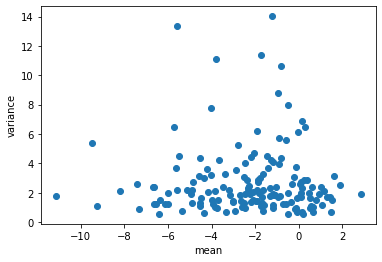

In [28]:
mean_variance_plot(table)

### Lowess regression

In [29]:
lowess = LowessRegression(sigma=1, span=0.1)

In [30]:
means, variances = get_means_and_variances(table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [31]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

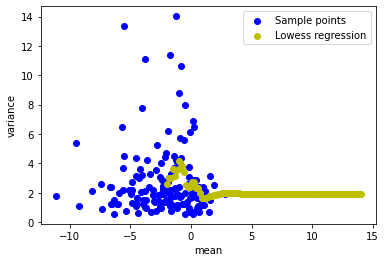

In [32]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

In [33]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [34]:
table /= np.sqrt(adj_var)

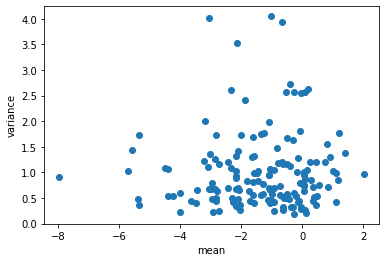

In [35]:
mean_variance_plot(table)

### Log transformation

In [36]:
log_table = table #np.log2(table)

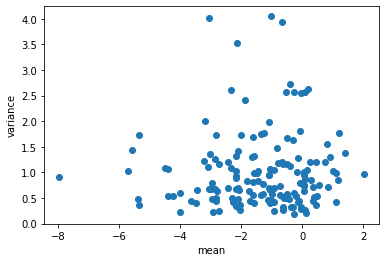

In [37]:
mean_variance_plot(log_table)

In [38]:
norm_log_table = log_table - np.mean(log_table)

In [39]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

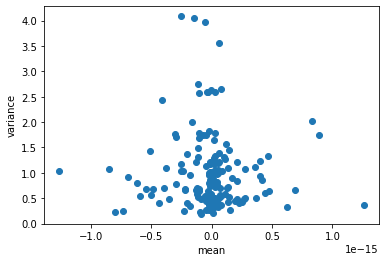

In [40]:
mean_variance_plot(norm_log_table)

### PCA

In [41]:
pca = decomposition.PCA(n_components=10)

In [42]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [43]:
pca.explained_variance_ratio_

array([0.21852316, 0.14843517, 0.05717269, 0.05570993, 0.04668069,
       0.03932488, 0.03422783, 0.02980777, 0.02559302, 0.02528071])

In [44]:
components = pca.transform(norm_log_table)

In [45]:
components.shape

(70, 10)

In [46]:
sum(controls)

32

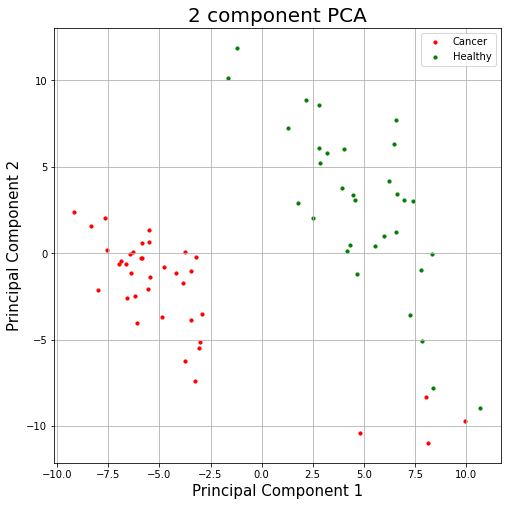

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [48]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

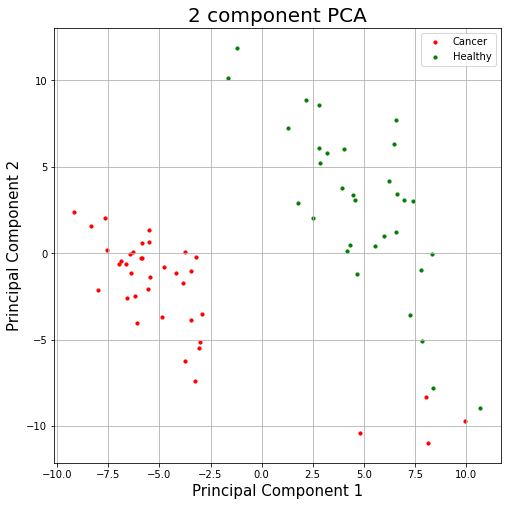

In [49]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [117]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [118]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

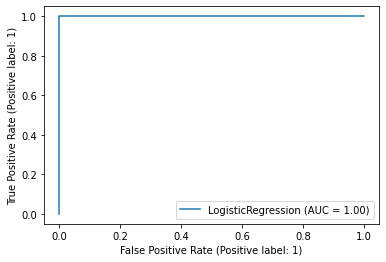

In [119]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [120]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

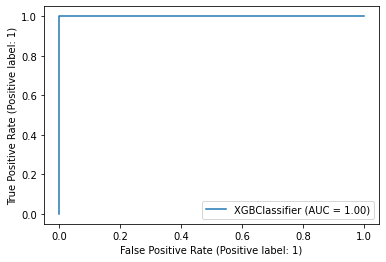

In [121]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [122]:
mask = np.array([True if m[:3] == "hsa" else False for m in mirnas])

In [123]:
len(mask), len(mirnas), len(norm_log_table.columns)

(157, 157, 157)

In [124]:
mirnas = mirnas[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [125]:
mirnas = [m[:-7] for m in mirnas]

In [126]:
mirnas = [m.replace("A", "a").replace("B", "b").replace("P", "p") for m in mirnas]

In [127]:
from Scripts import converters

In [128]:
sequences = converters.canonical_to_seq(mirnas, True)

In [129]:
sequences.count(None)

4

In [130]:
sequences = np.array(sequences)

In [131]:
mask = sequences != None

In [132]:
sequences = sequences[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [133]:
sequences[:10]

array(['CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG',
       'GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC',
       'CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAGGAGGUAACUAUACGACCUGCUGCCUUUCUUAGG',
       'CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG',
       'AGGCUGAGGUAGUAGUUUGUACAGUUUGAGGGUCUAUGAUACCACCCGGUACAGGAGAUAACUGUACAGGCCACUGCCUUGCCA',
       'UACAGUACUGUGAUAACUGAA', 'AAAAGUGCUUACAGUGCAGGUAG',
       'UAAAGUGCUGACAGUGCAGAU', 'UACCCUGUAGAUCCGAAUUUGUG',
       'UACCCUGUAGAACCGAAUUUGUG'], dtype=object)

In [134]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick

In [135]:
norm_log_table.head()

,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC,CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAGGAGGUAACUAUACGACCUGCUGCCUUUCUUAGG,CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG,AGGCUGAGGUAGUAGUUUGUACAGUUUGAGGGUCUAUGAUACCACCCGGUACAGGAGAUAACUGUACAGGCCACUGCCUUGCCA,UACAGUACUGUGAUAACUGAA,AAAAGUGCUUACAGUGCAGGUAG,UAAAGUGCUGACAGUGCAGAU,UACCCUGUAGAUCCGAAUUUGUG,UACCCUGUAGAACCGAAUUUGUG,...,UACCCAUUGCAUAUCGGAGUUG,UAUUCAUUUAUCCCCAGCCUACA,UGCGGGGCUAGGGCUAACAGCA,UGAGACCUCUGGGUUCUGAGCU,UCCAUUACACUACCCUGCCUCU,UAUUGCACUUGUCCCGGCCUGU,UCUUCUCUGUUUUGGCCAUGUG,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
VALUE,-0.630478,1.304453,-0.490071,-0.468067,0.542230,2.138511,0.057020,0.057166,-1.474241,-3.645962,...,0.611968,-0.238259,0.154064,-0.523919,2.131543,0.307685,0.919094,-0.781946,0.172908,False
VALUE,-0.351673,0.421022,-0.256367,-0.801357,-0.808344,-0.307740,-0.511289,-0.517377,-2.859242,-1.006186,...,-0.339583,-0.413945,-0.169971,-0.064520,0.479673,-0.050230,-0.474085,-0.138424,0.344394,False
VALUE,-0.520407,0.246115,0.088788,-0.172171,-0.187179,0.365640,-0.297700,-0.249005,-0.406074,-1.547878,...,-0.535041,-0.507738,-0.071464,-0.071334,0.328010,0.199559,0.306949,0.697204,0.178842,False
VALUE,0.129130,0.890160,-0.548640,-1.269589,-0.429495,0.961113,0.352515,0.264430,-1.727912,-1.074221,...,-0.066917,-1.917425,-0.517983,-0.145156,-0.321314,0.167757,0.144157,-1.163789,-0.949760,False
VALUE,0.045670,0.973167,-0.830677,-1.587163,-0.708097,-0.038117,-0.192481,-0.111039,-2.033539,-0.410066,...,-1.127674,-1.329472,-0.565292,-0.397286,-1.189268,-0.283252,-0.542981,-0.731349,-0.928398,False


In [136]:
norm_log_table.to_csv("../TransformedData/Halvorsen2016.csv", index=False)